In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
cd drive/MyDrive/experiments/

/content/drive/MyDrive/experiments


In [3]:
ls

data/  proj.ipynb


# baseline

In [21]:
import torch
from torchvision.datasets import LFWPeople
import torchvision.transforms as transforms

In [56]:
#train_dataset = LFWPeople("data/train", "train", transform=transforms.ToTensor(), download=True)
train_dataset = LFWPeople("data/train", "train", download=True)

Files already downloaded and verified


In [57]:
#test_dataset = LFWPeople("data/test", "test", transform=transforms.ToTensor(), download=True)
test_dataset = LFWPeople("data/test", "test", download=True)

Files already downloaded and verified


In [58]:
#BATCH_SIZE = 10
#train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=10, shuffle=False)
#test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=10, shuffle=False) 

In [59]:
class_to_idx = train_dataset.class_to_idx
def idx_to_class(idx):
    idx_to_class = {v:k for k,v in class_to_idx.items()}
    return idx_to_class[idx]

AJ_Cook


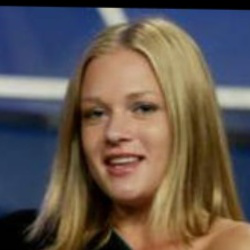

In [60]:
print(idx_to_class(train_dataset[0][1]))
train_dataset[0][0]

# using ResNet-50 to generate embedding

In [13]:
!pip install img2vec_pytorch

In [93]:
from img2vec_pytorch import Img2Vec
from PIL import Image
import numpy as np
from tqdm import tqdm

In [94]:
# Initialize Img2Vec with GPU
img2vec = Img2Vec(cuda=True, model="resnet50")

In [62]:
train_dataset[0]

(<PIL.Image.Image image mode=RGB size=250x250 at 0x7FA629F11450>, 0)

In [98]:
# generating embedding for training dataset
train_vectors = []
batch_size = 10

cur_idx = 0
cur_batch = []
train_labels = [train_dataset[i][1] for i in range(len(train_dataset))]

pbar = tqdm(total=len(train_dataset))
while cur_idx < len(train_dataset):
    if len(cur_batch) == batch_size:
        embeddings = img2vec.get_vec(cur_batch)
        train_vectors.append(embeddings)
        cur_batch = []
    else:
        cur_batch.append(train_dataset[cur_idx][0])
        cur_idx += 1
        pbar.update(1)
        if cur_idx >= len(train_dataset):
            embeddings = img2vec.get_vec(cur_batch)
            train_vectors.append(embeddings)
            break

pbar.close()
train_vectors = np.vstack(train_vectors)
print(train_vectors.shape)

100%|██████████| 9525/9525 [00:54<00:00, 174.28it/s]

(9525, 2048)


In [99]:
# generating embedding for testing dataset
test_vectors = []
batch_size = 10

cur_idx = 0
cur_batch = []
test_labels = [test_dataset[i][1] for i in range(len(test_dataset))]

pbar = tqdm(total=len(test_dataset))
while cur_idx < len(test_dataset):
    if len(cur_batch) == batch_size:
        embeddings = img2vec.get_vec(cur_batch)
        test_vectors.append(embeddings)
        cur_batch = []
    else:
        cur_batch.append(test_dataset[cur_idx][0])
        cur_idx += 1
        pbar.update(1)
        if cur_idx >= len(test_dataset):
            embeddings = img2vec.get_vec(cur_batch)
            test_vectors.append(embeddings)
            break

pbar.close()
test_vectors = np.vstack(test_vectors)
print(test_vectors.shape)

100%|██████████| 3708/3708 [00:21<00:00, 176.15it/s]

(3708, 2048)


# store output as npy file

In [103]:
from numpy import save
import json

In [101]:
save("data/resnet50_train_vectors.npy", train_vectors)
save("data/resnet50_test_vectors.npy", test_vectors)

In [105]:
with open("data/train_labels.json", "w+") as f:
    json.dump(train_labels, f)

with open("data/test_labels.json", "w+") as f:
    json.dump(test_labels, f)

# evaluation

In [118]:
import numpy as np
from tqdm import tqdm
import json
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics

In [109]:
# load data
train_vectors = np.load("data/resnet50_train_vectors.npy")
test_vectors = np.load("data/resnet50_test_vectors.npy")

train_labels = json.load(open("data/train_labels.json"))
test_labels = json.load(open("data/test_labels.json"))

print(train_vectors.shape, test_vectors.shape)
print(len(train_labels), len(test_labels))

(9525, 2048) (3708, 2048)
9525 3708


In [130]:
# search for similarity threshold 
pos_res = []
neg_res = []
for src_idx, (src_vec, src_label) in tqdm(enumerate(list(zip(train_vectors, train_labels))), total=len(train_vectors)):
    pos = []
    neg = []
    for tgt_idx, (tgt_vec, tgt_label) in enumerate(list(zip(train_vectors, train_labels))):
        if src_idx == tgt_idx:
            continue

        cos_sim = np.dot(src_vec, tgt_vec) / (np.linalg.norm(src_vec)*np.linalg.norm(tgt_vec))
        if src_label == tgt_label:
            pos.append(cos_sim)
        else:
            neg.append(cos_sim)
    
    pos_res.append(np.mean(pos))
    neg_res.append(np.mean(neg))

  0%|          | 0/9525 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
100%|██████████| 9525/9525 [18:07<00:00,  8.76it/s]


In [136]:
# store similarity scores
save("data/resnet50_train_pos_mean_cossim.npy", pos_res)
save("data/resnet50_train_neg_mean_cossim.npy", neg_res)

In [134]:
print(f"mean pos cos similarity: {np.nanmean(pos_res)}")
print(f"mean neg cos similarity: {np.nanmean(neg_res)}")

mean pos cos similarity: 0.8242755104015478
mean neg cos similarity: 0.7482385635375977


In [135]:
# test performance on testdataset using the best threshold
opt_th = 0.824
fp, fn, tp, tn = 0, 0, 0, 0
correct, incorrect = 0, 0
for src_idx, (src_vec, src_label) in tqdm(enumerate(list(zip(test_vectors, test_labels))), total=len(test_vectors)):
    pos = []
    neg = []
    for tgt_idx, (tgt_vec, tgt_label) in enumerate(list(zip(test_vectors, test_labels))):
        if src_idx == tgt_idx:
            continue

        cos_sim = np.dot(src_vec, tgt_vec) / (np.linalg.norm(src_vec)*np.linalg.norm(tgt_vec))
        is_same = True if cos_sim > opt_th else False
        if src_label == tgt_label:
            if is_same:
                correct += 1
                tp += 1
            else:
                incorrect += 1
                fn += 1
        else:
            if is_same:
                incorrect += 1
                fp += 1
            else:
                correct += 1
                tn += 1

acc = correct / (correct+incorrect)
precision = tp / (tp+fp)
recall = tp / (tp+fn)
f1 = 2*((precision*recall)/(precision+recall))


100%|██████████| 3708/3708 [03:11<00:00, 19.35it/s]

Accuracy: 0.8176975889516582
Precision: 0.012333170288589197
Recall: 0.6308692120227457
F1-Score: 0.024193372523730754


In [139]:
print(f"Accuracy: {acc}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-Score: {f1}")
print(tp, fp, tn, fn)

Accuracy: 0.8176975889516582
Precision: 0.012333170288589197
Recall: 0.6308692120227457
F1-Score: 0.024193372523730754
31064 2487672 11208644 18176


# try KNN

In [121]:
# search for best n
for n in range(1, 20):
    knn = KNeighborsClassifier(n_neighbors=n)
    knn.fit(train_vectors, train_labels)

    train_pred = knn.predict(train_vectors)
    acc = metrics.accuracy_score(train_labels, train_pred)
    print(f"n:{n}, acc:{acc}")

n:1, acc:1.0
n:2, acc:0.5505511811023622
n:3, acc:0.42351706036745407
n:4, acc:0.3573753280839895
n:5, acc:0.32388451443569555
n:6, acc:0.3000524934383202
n:7, acc:0.285249343832021
n:8, acc:0.27370078740157483
n:9, acc:0.26330708661417324
n:10, acc:0.2546981627296588
n:11, acc:0.24650918635170604
n:12, acc:0.24041994750656168
n:13, acc:0.23286089238845145
n:14, acc:0.22866141732283465
n:15, acc:0.2232020997375328
n:16, acc:0.2194225721784777
n:17, acc:0.2173228346456693
n:18, acc:0.21228346456692915
n:19, acc:0.20755905511811024


In [127]:
# using best n=1
knn = KNeighborsClassifier(n_neighbors=2)
knn.fit(test_vectors, test_labels)

# test on testset
test_pred = knn.predict(test_vectors)
acc = metrics.accuracy_score(test_labels, test_pred)
print(f"test acc:{acc}")

test acc:0.5612189859762675


In [123]:
acc

0.0